In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the image and thresholding

In [29]:
def BGR2GRAY(img):
    if (img.ndim==3):
        out=0.3*img[...,2]+0.59*img[...,1]+0.11*img[...,0]
    else:
        out=img[...,0]
        print("Invalid Dimension")
    return out

177.0


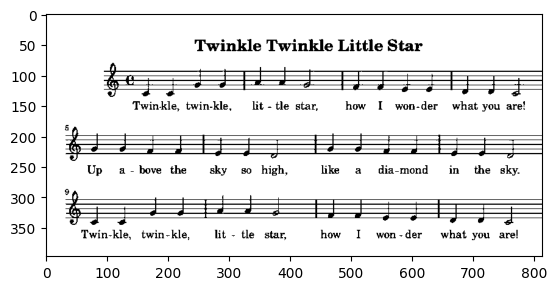

In [30]:
img_notes=cv2.imread("../data/inputs/notes.jpeg",cv2.IMREAD_GRAYSCALE)
# print(img_t)
ret,img_th=cv2.threshold(img_notes,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# plt.imshow(th_img)
print(ret)
plt.imshow(img_th,cmap="gray")

## Preprocessing

In [31]:
def make_disc(size,bg=0):
    size=int(size)
    if(size%2==0):
        size+=1
    K=np.ones((size,size))*bg
    radius=int(size//2)
    u,v=np.meshgrid(np.arange(size),np.arange(size))
    idx=(u-radius)**2+(v-radius)**2<=radius**2
    K[idx]=1
    # plt.imshow(K,cmap='gray')
    return K

In [32]:
def struc_slide(img,kernel,method=0,pad_img=True,round=True,ignore=-1):
    K=kernel.shape[0]
    # pad=(K-1)//2
    fg=img.max()
    img=img.astype('float64')
    out=np.zeros_like(img)
    if fg==0:
        return out
    if kernel.shape[1]%2==1:
        pad_x_min=(kernel.shape[1]-1)//2
        pad_x_max=pad_x_min
    else:
        pad_x_max=(kernel.shape[1])//2
        pad_x_min=pad_x_max-1
    if kernel.shape[0]%2==1:
        pad_y_min=(kernel.shape[0]-1)//2
        pad_y_max=pad_y_min
    else:
        pad_y_max=(kernel.shape[0])//2
        pad_y_min=pad_y_max-1
    #The input is padded with zeros on edges, so output size is same as input
    padding=((pad_y_min,pad_y_max),(pad_x_min,pad_x_max))

    if(pad_img):
        img=np.pad(img,padding)

    idx=kernel!=ignore
    for y in range(pad_y_min,img.shape[0]-pad_y_max):
        for x in range(pad_x_min,img.shape[1]-pad_x_max):
            sub_img=img[y-pad_y_min:y+pad_y_max+1,x-pad_x_min:x+pad_x_max+1]//fg
            prod=np.zeros_like(kernel)
            
            prod[idx]=(sub_img[idx]==kernel[idx])
            if method==0:
                out[y-pad_y_min,x-pad_x_min]=fg*((prod[idx]).sum()==(len(kernel[idx]))).astype('int')
            else:
                out[y-pad_y_min,x-pad_x_min]=fg*(prod[idx].sum()>0).astype('int')
    return out if not round else np.round(out)

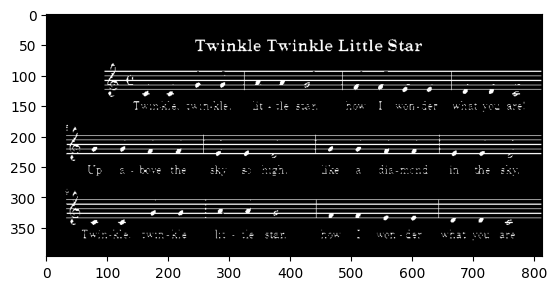

In [33]:
kernel=np.ones((3,3))*-1
kernel[1,:]=1
img_th_inv=(255-img_th)
# plt.imshow(img_th_inv,cmap='gray')
# cv2.imwrite("bin_img.png",img_th_inv)
eroded_img=struc_slide(img_th_inv,kernel)
plt.imshow(eroded_img,cmap='gray')

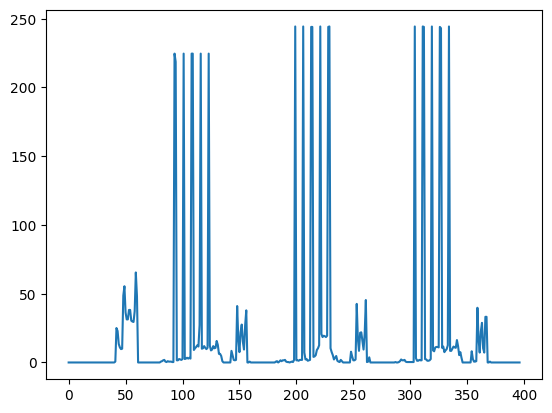

In [34]:
col_sum=eroded_img.sum(axis=1)/img_th_inv.shape[1]
plt.plot(col_sum)
# print(row_sum.shape,img_th_inv.shape)

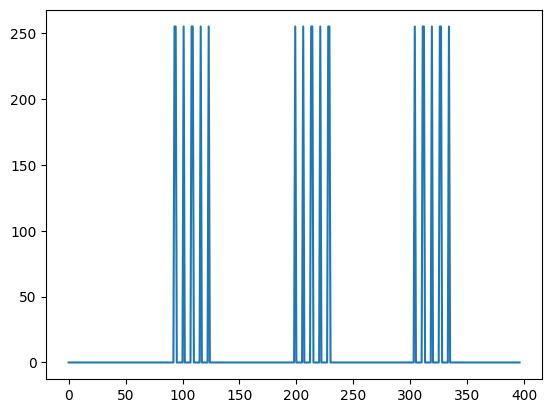

In [35]:
ret_col,img_col_th=cv2.threshold(col_sum.astype("uint8"),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.plot(img_col_th)

7.0


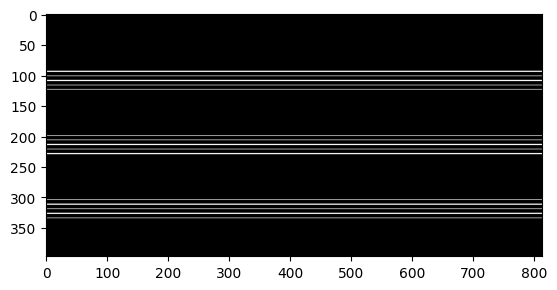

In [36]:
non_zero = np.where(img_col_th!=0)[0]
img_black = np.zeros((img_th_inv.shape))
img_black[non_zero, :] = 255
diff_shaff=np.diff(non_zero)
print(np.median(diff_shaff))
shaff_dist=np.median(diff_shaff)
plt.imshow(img_black, cmap='gray')
plt.show()

In [37]:
# Eroding with vertical lines of variable lenght

max_diff=0
k_size_opt=0
max_k=img_col_th.shape[0]
img_col_inv=255-img_col_th


In [38]:
def seg_mask(img_col_inv):
    num_peak_lst=[]
    idx_start=3
    for k_size in range(idx_start,max_k):
        k_ver=np.ones((k_size,1))
        eroded_ver=struc_slide(img_col_inv,k_ver)
        img_col_diff=np.abs(np.diff(eroded_ver,axis=0))
        num_peaks=img_col_diff.sum()
        # peak_diff=num_peaks-prev_peaks
        num_peak_lst.append(num_peaks)

    num_peak_arr=np.array(num_peak_lst)
    peak_diff=np.abs(np.diff(num_peak_arr,axis=0))
    k_size_opt=peak_diff.argmax()+2*idx_start
    # print(peak_diff.argmax())
    k_ver=np.ones((k_size_opt,1))
    eroded_ver=struc_slide(img_col_inv,k_ver)
    # plt.plot(num_peak_arr)
    # plt.plot(eroded_ver)
    mask_seg=eroded_ver.reshape(-1)==255
    mask_seg=mask_seg.astype('int')
    return mask_seg

In [39]:
# img_inv_fft=(np.fft.fft2(img_col_inv))
# img_inv_fftFilt=np.zeros_like(img_inv_fft)
# print(img_inv_fftFilt.shape)
# img_inv_fftFilt[-50:50,:]=img_inv_fft[-50:50,:]
# img_filt=np.fft.ifft2(img_inv_fftFilt)
# plt.plot(np.abs(img_filt))


In [40]:
mask_seg=seg_mask(img_col_inv)
# plt.imshow(img_th_inv,cmap="gray")

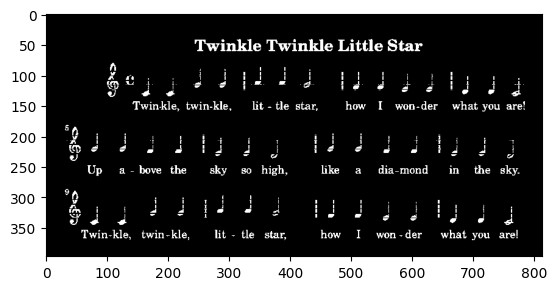

In [41]:
line_mask=img_col_th.reshape(-1)==255
# print(line_mask)
img_th_inv[line_mask,:]=0
plt.imshow(img_th_inv,cmap="gray")
# cv2.imwrite("bin_img.png",img_th_inv)

## Label

In [42]:
def label_img(img,shaff_dist):
    kernel=make_disc(shaff_dist//2,bg=-1)
    dilate=struc_slide(img,kernel,method=1).astype('uint8')
    dilate=struc_slide(dilate,kernel,method=1).astype('uint8')
    # closed=struc_slide(dilate,kernel,method=0).astype('uint8')
    # plt.imshow(closed,cmap="gray")
    plt.imshow(dilate,cmap="gray")
    analysis = cv2.connectedComponentsWithStats(dilate,4,cv2.CV_32S)
    (totalLabels, label_ids, values, centroid) = analysis
    return label_ids

## Segmentation

In [43]:
def segment_notes(img_th_inv,mask_seg):
    idx1=-1
    idx2=-1
    # print(mask_seg)
    mask_seg_mid=np.zeros_like(mask_seg)
    midpoints=[]
    for i in range(mask_seg.shape[0]-1):
        if((i==0 and mask_seg[i]>0) or (mask_seg[i]-mask_seg[i+1]<0)):
            idx1=i
        elif i+1==mask_seg.shape[0] or  (mask_seg[i]-mask_seg[i+1]>0):
            idx2=i
        if idx1!=-1 and idx2!=-1:
            # print(idx1,idx2)
            mask_seg_mid[(idx1+idx2)//2]=1
            midpoints.append((idx1+idx2)//2)
            idx1=-1
            idx2=-1
    img_segments=[]
    # orig_img_segments=[]
    # img_segments.append()
    for i in  range(len(midpoints)):
        # if i==0:
        #     tmp_img=img_th_inv[0:midpoints[i]].copy()
        if i==len(midpoints)-1:
            tmp_img=img_th_inv[midpoints[i]:img_th_inv.shape[0]].copy()
            # tmp_img1=(255-img_th)[midpoints[i]:img_th_inv.shape[0]].copy()
        else:
            tmp_img=img_th_inv[midpoints[i]:midpoints[i+1]].copy()
            # tmp_img1=(255-img_th)[midpoints[i]:midpoints[i+1]].copy()
        img_segments.append(tmp_img)
        # orig_img_segments.append(tmp_img1)
    # plt.imshow(img_segments[0],cmap="gray")
    print(midpoints)
    return img_segments#,orig_img_segments

[45, 160, 266, 365]
[45, 160, 266, 365]
[45, 160, 266, 365]


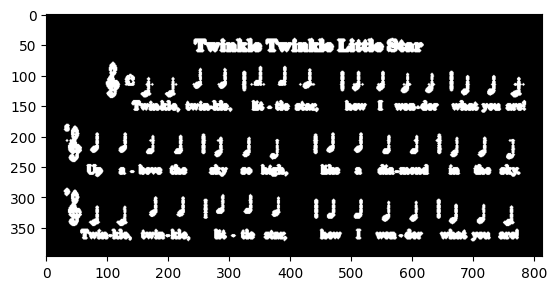

In [44]:
label_ids=label_img(img_th_inv,shaff_dist)
img_segments=segment_notes(img_th_inv,mask_seg)
orig_img_segments=segment_notes(255-img_th,mask_seg)
label_segments=segment_notes(label_ids,mask_seg)
# plt.imshow(img_segments[2],cmap='gray')

[ 0 25 26 34 35 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55
 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70]


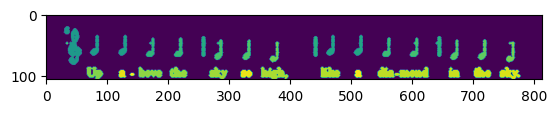

In [45]:
plt.imshow(label_segments[1])
print(np.unique(label_segments[1]))

## Clef Detection

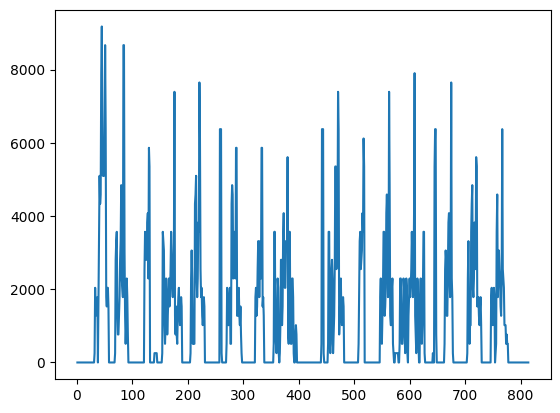

In [46]:
line1 = img_segments[0]
line2 = img_segments[1]
rowsums = np.sum(line2, axis=0)
xaxis = np.arange(1, rowsums.shape[0] + 1)
plt.plot(xaxis, rowsums)
plt.show()

In [47]:
def getClef(line, rowsums):
    clef_arr = []
    totpeaks = 1
    numpeaks = 0
    i=0

    while (i < rowsums.shape[0]):
        if (rowsums[i] > 0):
            i_entered = i
            while(rowsums[i] > 0):
                clef_arr.append(i)
                i = i+1

            if (np.abs(i - i_entered) <= 3):
                totpeaks = 2
            numpeaks = numpeaks+1 
            if (numpeaks >= totpeaks):
                break

        else:
            i = i+1

    return line[:, clef_arr]

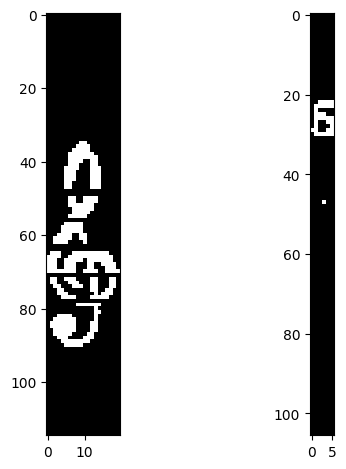

In [48]:
clef_arr_t = getClef(line1, np.sum(line1, axis=0))
clef_arr_b = getClef(line2, np.sum(line2, axis=0))

plt.subplot(1,2,1)
plt.imshow(clef_arr_t, cmap='gray')

plt.subplot(1,2,2)
plt.imshow(clef_arr_b, cmap='gray')

plt.tight_layout()
plt.show()

/tmp/ipykernel_2008/2747750232.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  noteWithoutStemMask = np.array(noteWithoutStemMask)


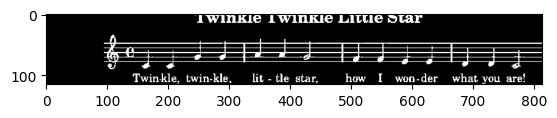

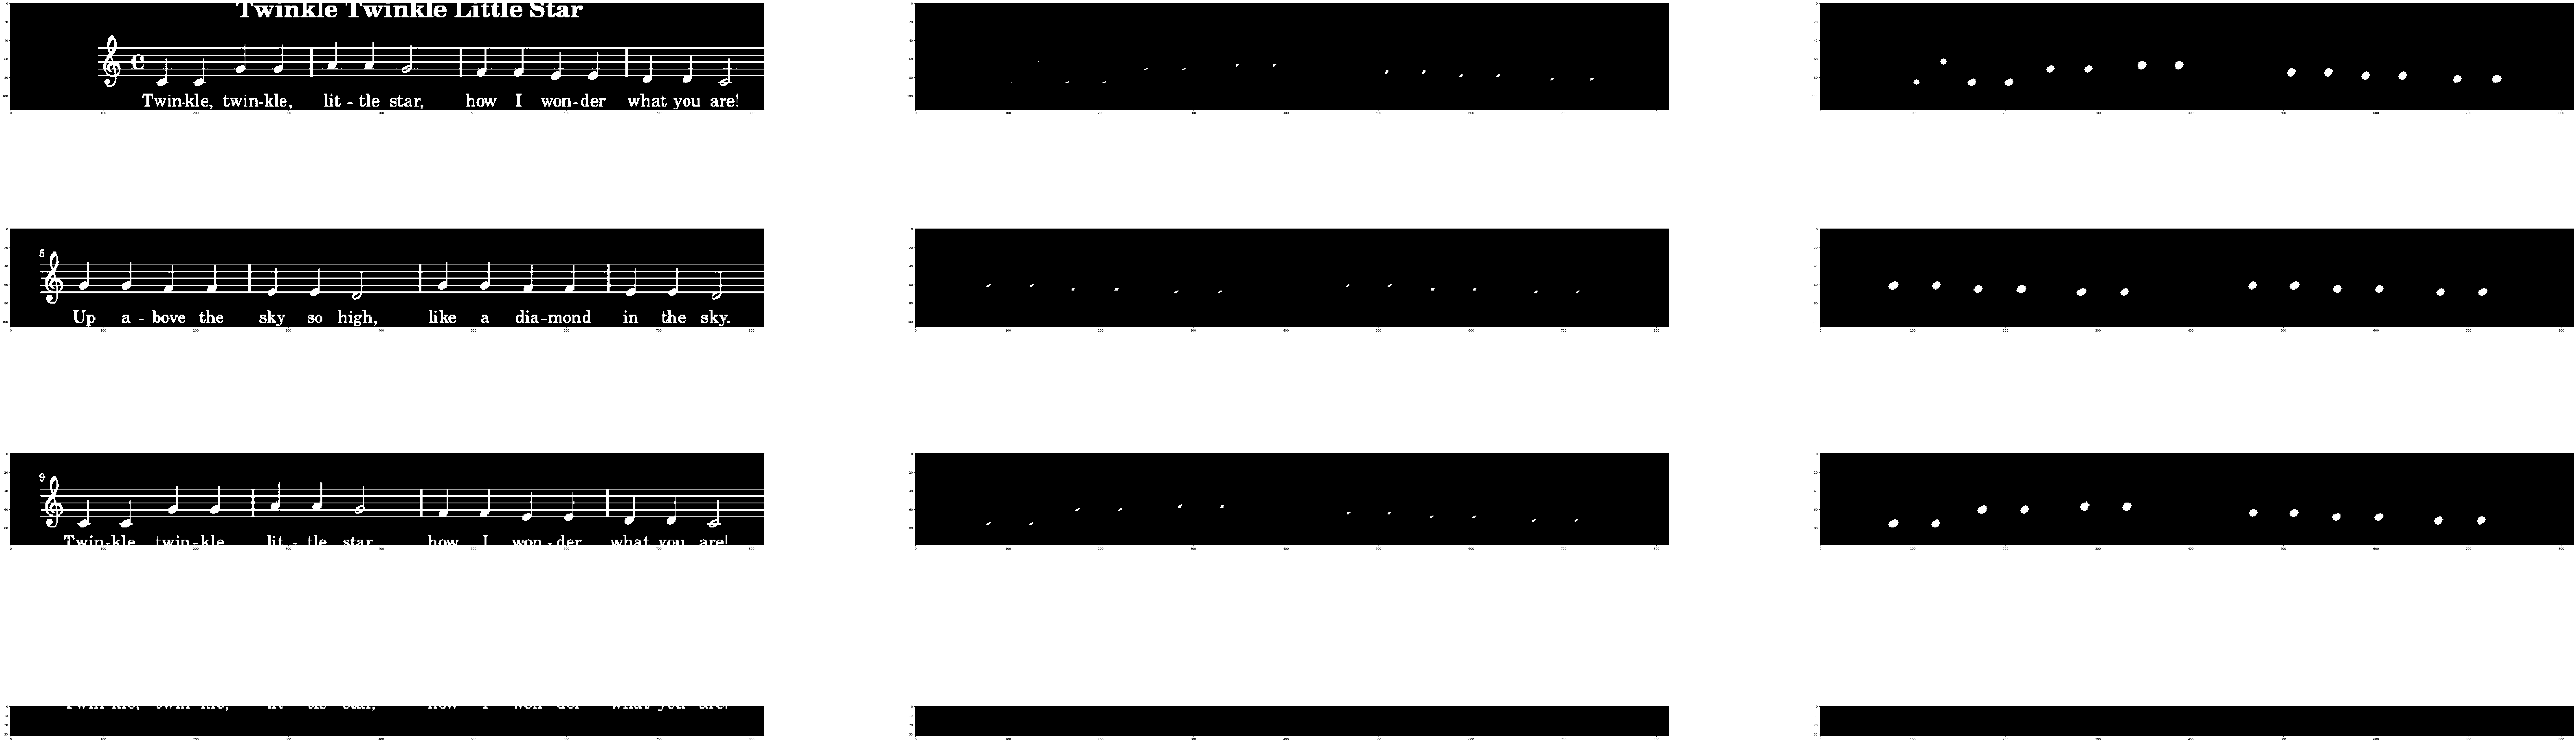

In [49]:
## Section 2.2.3
# make_disc(shaff_dist)
plt.imshow(orig_img_segments[0],cmap='gray')
fig,axes=plt.subplots(len(orig_img_segments),3,figsize=[150,50])
kernel=make_disc(shaff_dist,bg=-1)
note_wo_hole=[]

# adding new varibale to store note without stem mask
noteWithoutStemMask = []

for i,img in enumerate(orig_img_segments):
    test_segment1=struc_slide(img,kernel)
    test_segment2=struc_slide(test_segment1,kernel,method=1)
    note_wo_hole.append(test_segment2)
    axes[i,1].imshow(test_segment1,cmap='gray')
    axes[i,2].imshow(test_segment2,cmap='gray')
    axes[i,0].imshow(img,cmap='gray')

    noteWithoutStemMask.append(test_segment2)

noteWithoutStemMask = np.array(noteWithoutStemMask)

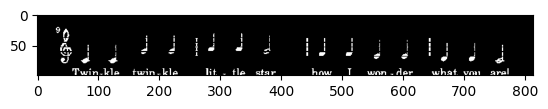

In [50]:
plt.imshow(img_segments[2],cmap='gray')
kernel=make_disc(shaff_dist//2,bg=-1)
dilate=struc_slide(img_segments[2],kernel,method=1)
closed=struc_slide(dilate,kernel,method=0)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]


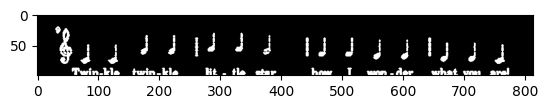

In [51]:
plt.imshow(dilate,cmap='gray')
closed=closed.astype('uint8')
dilate=dilate.astype('uint8')

analysis = cv2.connectedComponentsWithStats(dilate,4,cv2.CV_32S)
(totalLabels, label_ids, values, centroid) = analysis
print(np.unique(label_ids))


[ 0  3  4  5  6 10 11 13 14 15 16 17 18]
0
3
4
5
6
10
11
13
14
15
16
17
18
47


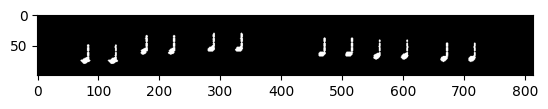

In [52]:
n_label=label_ids*(note_wo_hole[2]!=0)
print(np.unique(n_label))
out=np.zeros_like(label_ids)
for label in np.unique(n_label):
    print(label)
    if label==0:
        continue
    idx=label_ids==label
    out[idx]=255
plt.imshow(out,cmap='gray')
print(totalLabels)

## Symbol to Musical Note Detection and Mapping

In [53]:
from my_functions import LineWidthNorm, lineToNoteMap, spaceToNoteMap
from my_functions import getStaffLineNums, NoteLineAnding, noteIdentification, getNoteSequence
from my_functions import getSegmentNotes, labelRemapping

In [54]:
lineMask = segment_notes(img_black, mask_seg)
noStemLabelledNotes = []
for i in range(len(lineMask)):
    temp = label_segments[i] * noteWithoutStemMask[i]
    noStemLabelledNotes.append(temp)
    lineMask[i] = LineWidthNorm(lineMask[i])

imgNotes = []
for i in range(len(lineMask)):
    imgNotes.append(getSegmentNotes(lineMask[i], noStemLabelledNotes[i]))

for i in range(len(imgNotes)):
    print(imgNotes[i])

[45, 160, 266, 365]
[[['b', 'g', 'g', 'a', 'a', 'f', 'f', 'e', 'e', 'e', 'e']]]
[[['g', 'g', 'f', 'f', 'e', 'e', 'g', 'g', 'f', 'f', 'e', 'e']]]
[[['g', 'g', 'a', 'a', 'f', 'f', 'e', 'e', 'e', 'e']]]
[[[]]]
